In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 18
batch_size = 16
state_dim = 1000
random_feature_dim = 10000
epochs = 10
n_obs = 16

num_desired_trajectories=200
# choose env from "random", "small world" or "dead ends"
env = GraphEnv(size=n_nodes, n_items=n_obs, env='random', batch_size=batch_size, num_desired_trajectories=num_desired_trajectories)

dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories, n_obs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

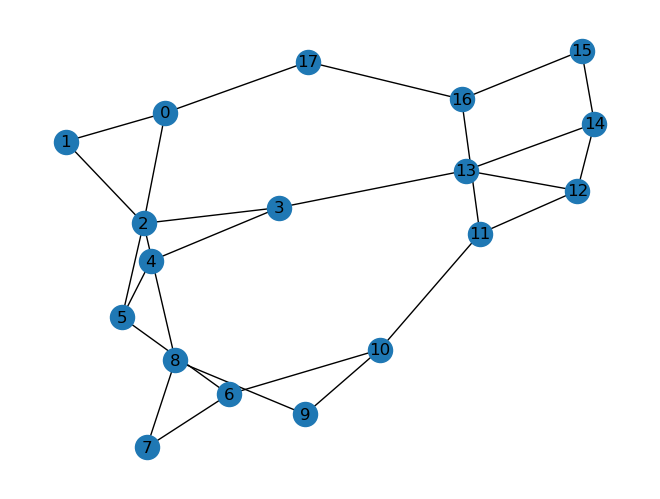

number of actions: 50


In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float))

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

# for trajectory in dataloader:
#     print(trajectory)
#     break


In [ ]:
A = torch.randn(3, 4)
v =torch.randn(4)
A @ v

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = dataloader,)

loss_record= trainer.train(epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AttributeError: 'POCML' object has no attribute 'infer_hd_state_from_binding'

In [ ]:

class PartiallyObservableCML(torch.nn.Module):
    """
        Partially Observable Compositional Memory Learning (CML) model.

        Attributes:
        -----------
        n_states : int
            Number of states in the model.
        n_obs : int
            Number of observations in the model.
        n_act : int
            Number of actions in the model.
        embedding_dim : int
            Dimension of the embedding space.
        U : torch.nn.Parameter
            Embedding matrix for observations.
        Q : torch.nn.Parameter
            Embedding matrix for states.
        V : torch.nn.Parameter
            Embedding matrix for actions.
        M : torch.Tensor
            Compositional memory matrix.
        z : torch.Tensor
            Current state embedding.
    """
    def __init__(self, n_states, n_obs, n_act, embedding_dim):
        super().__init__()
        self.n_states = n_states
        self.n_obs = n_obs
        self.n_act = n_act
        self.embedding_dim = embedding_dim

        self.U = torch.nn.Parameter(torch.randn(embedding_dim, n_obs), requires_grad=False)
        self.Q = torch.nn.Parameter(torch.randn(embedding_dim, n_states))
        self.V = torch.nn.Parameter(torch.randn(embedding_dim, n_act))

        self.reset()

    # assume we start in the same state every time
    def reset(self):
        self.M = torch.zeros(self.embedding_dim, self.embedding_dim)
        self.z = self.Q[:, 0] # arbitrary state selection

    def forward(self, o, a, o_next):
        print(a.shape, self.z.shape, self.V[:, a].shape)
        z_pred = self.z.detach() + self.V[:, a]
        z_next = self.closest_state(z_pred.detach(), metric='euclidean')
        
        x_pred = self.M.T @ z_next
        x_next = self.U[:, o_next]
        print(self.M.shape, z_next.shape, x_pred.shape)

        self.z = z_next
        self.M += torch.outer(z_next, x_next).detach()

        return z_pred, z_next, x_pred, x_next

    def closest_state(self, s, metric='dot'):
        if metric == 'dot':
            return self.Q[torch.argmax(self.Q.T @ s)]
        elif metric == 'euclidean':
            s = s.unsqueeze(1)
            print("Q", self.Q.shape, s.shape)
            print("L", torch.linalg.norm(self.Q.detach() - s, dim=0).shape)
            return self.Q[:, torch.argmin(torch.linalg.norm(self.Q.detach() - s, dim=0))]
        else:
            raise NotImplementedError

In [ ]:
class Agent(torch.nn.Module):
    """
        A CML agent model with parameterized matrices 
        for state (Q) and action (V) representation.

        Attributes:
            o_size (int): Size of the observation space.
            a_size (int): Size of the action space.
            z_size (int): Size of the latent space.
            s_dim (int): Dimension of the state space.
            device (torch.device, optional): Device to run the computations on.

        Methods:
            forward(o_pre, action, o_next):
                Computes the prediction error based on the previous observation, action taken, and next observation.
            
            plan(start, goal, env, weight=False):
                Plans a sequence of actions to reach the goal from the start state.
            
            move_one_step(loc, goal, a_record, affordance, action_to_node, next_node_to_action, weight=False, w_connection=None):
                Determines the next step to take based on the current location and goal.
        """
    def __init__(self, o_size, a_size, z_size, s_dim, device=None):

        super(Agent, self).__init__()
        self.Q = torch.nn.Parameter(1*torch.randn(s_dim, o_size, device=device))
        self.V = torch.nn.Parameter(0.1*torch.randn(s_dim, a_size, device=device))
        self.Z = torch.nn.Parameter(0.1*torch.randn(s_dim, z_size, device=device))
        self.W = torch.nn.Parameter(0.1*torch.randn(a_size, s_dim, device=device))
        self.o_size = o_size
        self.a_size = a_size

        self.device = device

    def forward(self, o_pre, action, o_next):
        prediction_error = self.Q[:,o_next]-(self.Q[:,o_pre]+self.V[:,action])
        return prediction_error
    
    def plan(self, start, goal, env, weight=False):
        a_record = []
        o_record = []
        loc = int(start)
        length = 0
        for i in range(self.o_size):
            o_record.append(loc)
            if loc==goal:
                if weight:
                    return length, o_record
                else:
                    return i, o_record
            loc, action = self.move_one_step(loc, goal, a_record, env.affordance[loc], 
                    env.action_to_node, env.node_to_action_matrix[loc], weight)
            a_record.append(action)
            if weight:
                length += w_connection[o_record[-1],loc]

        if weight:
            return length, o_record
        else:
            return i, o_record
        
    def move_one_step(self, loc, goal, a_record, affordance, action_to_node,
                      next_node_to_action, weight=False, w_connection=None):  
        affordance_vector = torch.zeros(self.a_size, device=self.device)
        affordance_vector[affordance] = 1
        if weight:    
            for a in affordance:
                a = a.item()
                affordance_vector[a]/=(w_connection[action_to_node[a][0],
                                                    action_to_node[a][1]])
        affordance_vector_fix = affordance_vector.clone()
        not_recommended_actions = a_record
        affordance_vector_fix[not_recommended_actions] *= 0. # Eliminate not recommended actions
    
        delta = self.Q[:,goal]-self.Q[:,loc]
        utility = (self.W@delta) * affordance_vector_fix
        if torch.max(utility)!=0:
            action_idx = torch.argmax(utility).item()
        else:
            utility = (self.V.T@delta) * affordance_vector
            action_idx = torch.argmax(utility).item()

            
        return action_to_node[action_idx][1].item(), action_idx


In [ ]:
# POCML's train_model
def train_model(model: PartiallyObservableCML, dataloader, epochs, norm=False):
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()
    losses = []
    for epoch in tqdm(range(epochs), desc="Epochs"):
        loss_over_epoch = 0
        for trajectory in dataloader:
            model.reset()
            
            # "break in" traj w/o backprop first
            for i in range(trajectory.shape[0]):
                o, a, o_next = trajectory[0,i,0], trajectory[0,i,1], trajectory[0,i,2]
                z_pred, z_next, x_pred, x_next = model(o, a, o_next)

                loss1 = loss_fn(z_pred, z_next)
                loss2 = loss_fn(x_pred, x_next)

                optim.zero_grad()
                loss1.backward()
                optim.step()

                optim.zero_grad()
                loss2.backward()
                optim.step()

                loss_over_epoch += loss1.item() + loss2.item()

            if norm:
                model.V.data = model.V / torch.norm(model.V, dim=0)
            
        losses.append(loss_over_epoch)
        print(f"Epoch {epoch} | Loss: {loss_over_epoch}")
    return losses

In [ ]:
# OG CML's train model
def train_model(model: Agent, dataloader, epochs, norm=False):
    with torch.no_grad():
        loss_record = []
        for epoch in tqdm(range(epochs), desc="Epochs"):
            count = 0
            for trajectory in dataloader:
                count += 1
                o_pre, action, o_next = trajectory[0,:,0].to(device),\
                                        trajectory[0,:,1].to(device),\
                                        trajectory[0,:,2].to(device)
                identity = torch.eye(model.a_size).to(device)
                state_diff = model.Q[:,o_next]-model.Q[:,o_pre]
                prediction_error = state_diff - model.V[:,action]
                desired = identity[action].T
                
                # Core learning rules:
                model.Q[:,o_next] += -0.1 * prediction_error
                model.V[:,action] += 0.01 * prediction_error
                model.W += 0.01 * desired@state_diff.T
                if norm:
                    model.V.data = model.V / torch.norm(model.V, dim=0)

                loss = nn.MSELoss()(prediction_error, torch.zeros_like(prediction_error))
                loss_record.append(loss.cpu().item())
    return loss_record

In [ ]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 32
batch_size = 32
state_dim = 1000
epochs = 10
n_obs = 10

num_desired_trajectories=200
# choose env from "random", "small world" or "dead ends"
env = GraphEnv(size=n_nodes, n_items=n_obs, env='random', batch_size=batch_size, num_desired_trajectories=num_desired_trajectories)

dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories, n_obs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = PartiallyObservableCML(n_states=env.size, n_obs=n_obs, n_act=env.n_actions, embedding_dim=state_dim)


loss_record= train_model(model, dataloader, epochs, norm=False)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([]) torch.Size([1000]) torch.Size([1000])
Q torch.Size([1000, 32]) torch.Size([1000, 1])
L torch.Size([32])
torch.Size([1000, 1000]) torch.Size([1000]) torch.Size([1000])


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1000, 1000]] is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 